# Importación de librerías

In [16]:
import pandas as pd
import numpy as np
import time 

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [18]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv" 


mfcc_n_coeficiente = "20"

# Dataset input
dataset_input_path = f"../../data/processed/dataset_mfcc_{mfcc_n_coeficiente}.csv"

# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_input_path, sep=";")
dataset_urbansound8k_df.head(3)


,fold,classID,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,delta2_mfcc_var_11,delta2_mfcc_var_12,delta2_mfcc_var_13,delta2_mfcc_var_14,delta2_mfcc_var_15,delta2_mfcc_var_16,delta2_mfcc_var_17,delta2_mfcc_var_18,delta2_mfcc_var_19,delta2_mfcc_var_20
0,5,3,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,...,41.223183,27.885939,51.33420,47.697777,49.812220,14.355281,46.313560,44.401760,110.738230,25.753720
1,5,2,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,...,38.453808,28.922888,32.19454,32.540830,27.270597,28.516123,27.197691,23.052114,32.825718,28.952673
2,5,2,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,...,25.948908,28.198223,31.85179,33.908460,27.358440,25.454557,29.894941,28.242071,25.876347,25.493631


In [19]:
print(f"Cantidad de columnas: {dataset_urbansound8k_df.shape[1]}")
print(f"Cantidad de filas: {dataset_urbansound8k_df.shape[0]}")

print("Columnas del dataset:")
contador = 0
for name in dataset_urbansound8k_df.columns:
    contador +=1
    if contador%5==0:
        print("")        
    print(f"'{name}'", end=", ")

Cantidad de columnas: 222
Cantidad de filas: 8732
Columnas del dataset:
'fold', 'classID', 'mfcc_mean_1', 'mfcc_mean_2', 
'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 
'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 
'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_mean_16', 'mfcc_mean_17', 
'mfcc_mean_18', 'mfcc_mean_19', 'mfcc_mean_20', 'mfcc_median_1', 'mfcc_median_2', 
'mfcc_median_3', 'mfcc_median_4', 'mfcc_median_5', 'mfcc_median_6', 'mfcc_median_7', 
'mfcc_median_8', 'mfcc_median_9', 'mfcc_median_10', 'mfcc_median_11', 'mfcc_median_12', 
'mfcc_median_13', 'mfcc_median_14', 'mfcc_median_15', 'mfcc_median_16', 'mfcc_median_17', 
'mfcc_median_18', 'mfcc_median_19', 'mfcc_median_20', 'mfcc_min_1', 'mfcc_min_2', 
'mfcc_min_3', 'mfcc_min_4', 'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 
'mfcc_min_8', 'mfcc_min_9', 'mfcc_min_10', 'mfcc_min_11', 'mfcc_min_12', 
'mfcc_min_13', 'mfcc_min_14', 'mfcc_min_15', 'mfcc_min_16', 'mfcc

# Generación datos de entrenamiento y prueba

In [20]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas_mfcc = [col for col in dataset_urbansound8k_df.columns if 'mfcc' in col]
columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X_caracteristicas = dataset_urbansound8k_df[columnas_caracteristicas_mfcc]  # 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

In [21]:
# Iniciar el experimento en MLflow
mlflow.set_experiment(f"FINAL MFCC{mfcc_n_coeficiente} - V1")

2024/11/02 23:30:06 INFO mlflow.tracking.fluent: Experiment with name 'FINAL MFCC20 - V1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/colbe/Documents/VIU/TFM/tfm-clasificador-fuentes-sonoras-ciudad/notebooks/modelado/mlruns/215287537433083468', creation_time=1730608206357, experiment_id='215287537433083468', last_update_time=1730608206357, lifecycle_stage='active', name='FINAL MFCC20 - V1', tags={}>

## KNeighborsClassifier

Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.588993857473947
Fold 1 Accuracy: 0.5304
Tiempo de entrenamiento (segundos): 8.0975


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5954894059534641
Fold 2 Accuracy: 0.5766
Tiempo de entrenamiento (segundos): 4.6311


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.6012467579368987
Fold 3 Accuracy: 0.5200
Tiempo de entrenamiento (segundos): 4.7453


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5940358422939068
Fold 4 Accuracy: 0.6303
Tiempo de entrenamiento (segundos): 4.6628


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5720766268391428
Fold 5 Accuracy: 0.6442
Tiempo de entrenamiento (segundos): 4.7339


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5828670646033702
Fold 6 Accuracy: 0.5832
Tiempo de entrenamiento (segundos): 4.1456


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5932407630232148
Fold 7 Accuracy: 0.5382
Tiempo de entrenamiento (segundos): 5.0948


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5941134230068656
Fold 8 Accuracy: 0.5335
Tiempo de entrenamiento (segundos): 5.2021


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5692169801683076
Fold 9 Accuracy: 0.6605
Tiempo de entrenamiento (segundos): 4.8781


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Mejor Score: 0.5799780205676148
Fold 10 Accuracy: 0.6045
Tiempo de entrenamiento (segundos): 5.0789


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.5821
Desviación estándar: 0.0487
Tiempo de entrenamiento promedio (segundos): 5.1270


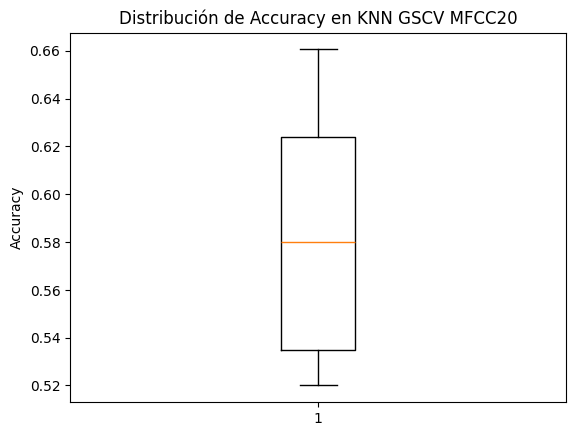

In [22]:
# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros para GridSearchCV
param_distributions = {
    'n_neighbors': [9],  # Número de vecinos a considerar
    'weights': ['uniform'],  # Función de peso a usar
    'metric': ['manhattan']  # Métrica de distancia
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K

    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn, 
        param_grid=param_distributions, 
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1  # Usar todos los núcleos disponibles
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_knn = grid_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_    
    
    # Predecir y evaluar
    y_pred = best_knn.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')   

    fold_accuracies.append(accuracy_val)
    
    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")  
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"KNN GSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "GSCV", 
            "model": "KNN"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_knn, f"knn_gscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en KNN GSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

In [23]:
# Definir el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir la rejilla de parámetros para GridSearchCV
param_distributions = {
    'n_estimators': [500],  # Número de árboles en el bosque
    'max_depth': [50],  # Máxima profundidad de cada árbol
    'min_samples_split': [2],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [False]  # Método para seleccionar muestras para construir cada árbol
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf, 
        param_grid=param_distributions, 
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1  # Usar todos los núcleos disponibles
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_rf = grid_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_rf.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')   
    
    fold_accuracies.append(accuracy_val)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"RF GSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "GSCV", 
            "model": "RF"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_rf, f"rf_gscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en RF GSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()

KeyboardInterrupt: 

## SVM

Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.70860131926549
Fold 1 Accuracy: 0.6724
Tiempo de entrenamiento (segundos): 211.4402


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.7015413362797348
Fold 2 Accuracy: 0.6115
Tiempo de entrenamiento (segundos): 196.7604


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.7010046291736434
Fold 3 Accuracy: 0.5827
Tiempo de entrenamiento (segundos): 185.0873


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6915365508043678
Fold 4 Accuracy: 0.6929
Tiempo de entrenamiento (segundos): 171.6258


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6767339784733879
Fold 5 Accuracy: 0.6987
Tiempo de entrenamiento (segundos): 212.5467


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6850320856470739
Fold 6 Accuracy: 0.6744
Tiempo de entrenamiento (segundos): 204.4354


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.001, 'kernel': 'linear'}
Mejor Score: 0.6832821549469765
Fold 7 Accuracy: 0.7136
Tiempo de entrenamiento (segundos): 256.3924


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6850698026927535
Fold 8 Accuracy: 0.6774
Tiempo de entrenamiento (segundos): 210.1603


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6831504041681032
Fold 9 Accuracy: 0.7243
Tiempo de entrenamiento (segundos): 187.8662


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'C': 0.0001, 'kernel': 'linear'}
Mejor Score: 0.6877574561614606
Fold 10 Accuracy: 0.6810
Tiempo de entrenamiento (segundos): 224.4931


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.6729
Desviación estándar: 0.0417
Tiempo de entrenamiento promedio (segundos): 206.0808


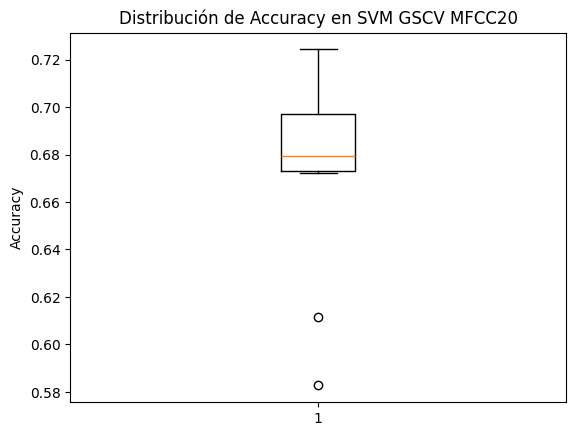

In [ ]:

# Definir el modelo SVM
svm = SVC(random_state=42)

# Definir la rejilla de parámetros para GridSearchCV
param_distributions = {
    'C': [0.0001],  
    'kernel': ['linear']
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=svm, 
        param_grid=param_distributions, 
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1  # Usar todos los núcleos disponibles
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    grid_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_svm = grid_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_svm.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted') 
    fold_accuracies.append(accuracy_val)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"SVM GSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "GSCV", 
            "model": "SVM"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_svm, f"svm_gscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en SVM GSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()


# Grafico de comparacion

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


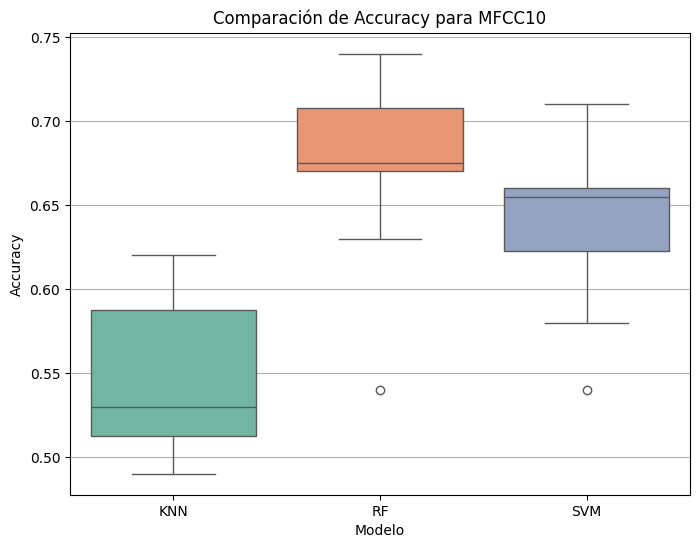

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


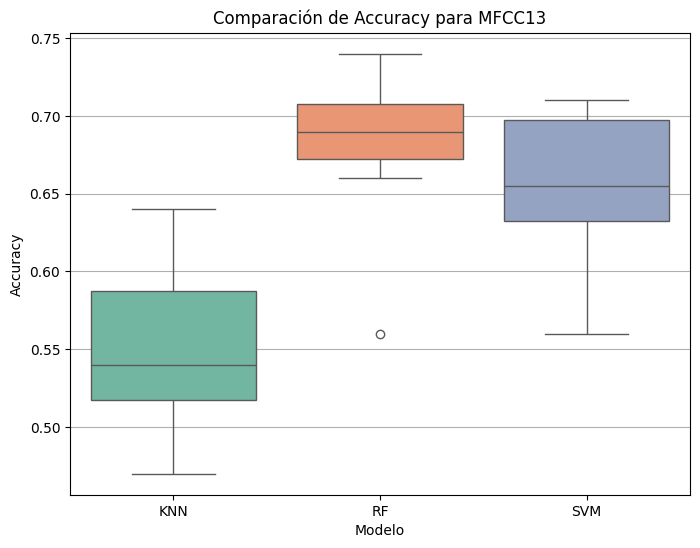

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


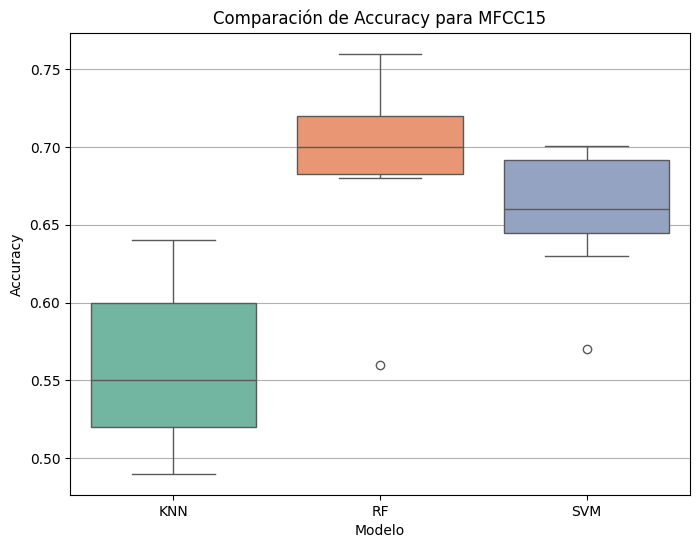

C:\Users\colbe\AppData\Local\Temp\ipykernel_344\388596318.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


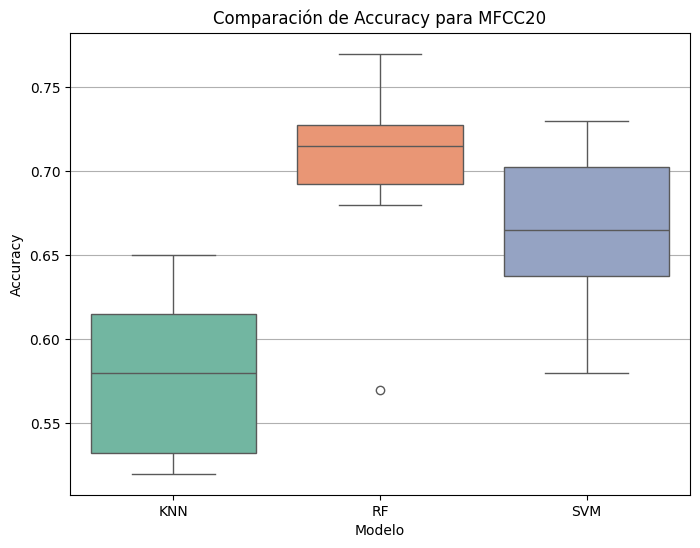

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Organizar tus datos en un DataFrame

# Crear una lista con los nombres de los folds
folds = ['FOLD1', 'FOLD2', 'FOLD3', 'FOLD4', 'FOLD5', 'FOLD6', 'FOLD7', 'FOLD8', 'FOLD9', 'FOLD10']

# Datos de exactitud para cada modelo y configuración de MFCC
data = {
    'FOLD': folds * 12,  # 10 folds para cada combinación de modelo y MFCC (10 folds x 12 combinaciones)
    'MFCC': ['MFCC10'] * 30 + ['MFCC13'] * 30 + ['MFCC15'] * 30 + ['MFCC20'] * 30,
    'Modelo': (['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10) * 4,
    'Accuracy': [
        # MFCC10 - KNN
        0.51, 0.53, 0.49, 0.58, 0.62, 0.52, 0.50, 0.53, 0.62, 0.59,
        # MFCC10 - RF
        0.67, 0.63, 0.54, 0.72, 0.71, 0.67, 0.68, 0.67, 0.70, 0.74,
        # MFCC10 - SVM
        0.62, 0.58, 0.54, 0.66, 0.66, 0.65, 0.71, 0.71, 0.66, 0.63,
        # MFCC13 - KNN
        0.51, 0.54, 0.47, 0.59, 0.64, 0.54, 0.51, 0.54, 0.64, 0.58,
        # MFCC13 - RF
        0.68, 0.66, 0.56, 0.70, 0.71, 0.69, 0.69, 0.67, 0.71, 0.74,
        # MFCC13 - SVM
        0.64, 0.62, 0.56, 0.63, 0.66, 0.66, 0.71, 0.71, 0.71, 0.65,
        # MFCC15 - KNN
        0.51, 0.55, 0.49, 0.60, 0.64, 0.55, 0.52, 0.52, 0.64, 0.60,
        # MFCC15 - RF
        0.69, 0.68, 0.56, 0.72, 0.74, 0.68, 0.69, 0.72, 0.71, 0.76,
        # MFCC15 - SVM
        0.66, 0.63, 0.57, 0.66, 0.66, 0.673, 0.698, 0.699, 0.701, 0.64,
        # MFCC20 - KNN
        0.53, 0.57, 0.52, 0.62, 0.65, 0.59, 0.54, 0.53, 0.65, 0.60,
        # MFCC20 - RF
        0.71, 0.72, 0.57, 0.70, 0.76, 0.69, 0.68, 0.73, 0.72, 0.77,
        # MFCC20 - SVM
        0.63, 0.63, 0.58, 0.67, 0.71, 0.68, 0.71, 0.66, 0.73, 0.66
    ]
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Ajustar la columna 'Modelo' para que se repita correctamente
models = ['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10
df['Modelo'] = models * 4  # Multiplicar por 4 porque hay 4 configuraciones de MFCC

# Paso 2: Crear un DataFrame separado para cada MFCC y generar los boxplots

mfcc_list = ['MFCC10', 'MFCC13', 'MFCC15', 'MFCC20']

for mfcc in mfcc_list:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')
    plt.title(f'Comparación de Accuracy para {mfcc}')
    plt.ylabel('Accuracy')
    plt.xlabel('Modelo')
    plt.grid(axis='y')
    plt.show()


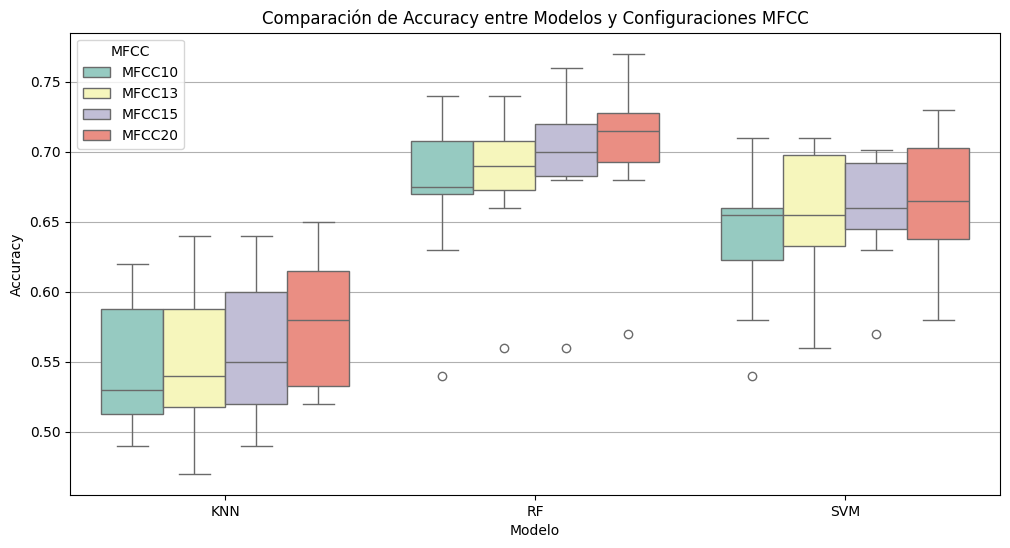

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Modelo', y='Accuracy', hue='MFCC', data=df, palette='Set3')
plt.title('Comparación de Accuracy entre Modelos y Configuraciones MFCC')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.legend(title='MFCC')
plt.grid(axis='y')
plt.show()
